In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
download_list=os.listdir("Downloads/input/")
print(download_list)

['sampleSubmission.csv', 'test1', 'train']


In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
filenames = os.listdir("Downloads/input/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,category
21162,dog.9995.jpg,1
21163,dog.9996.jpg,1
21164,dog.9997.jpg,1
21165,dog.9998.jpg,1
21166,dog.9999.jpg,1


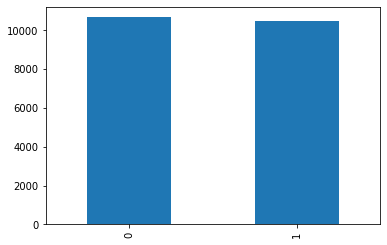

In [7]:
df['category'].value_counts().plot.bar()

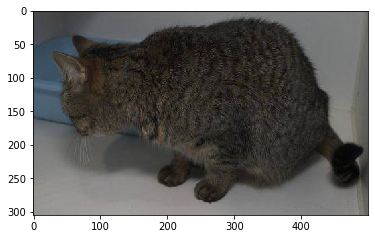

In [8]:
sample=random.choice(filenames)
image=load_img("Downloads/input/train/"+sample)
plt.imshow(image)

In [312]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [313]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_41 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_42 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 64)      

In [314]:
earlystop=EarlyStopping(patience=10)

In [315]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [316]:
callbacks=[earlystop,learning_rate_reduction]

In [317]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [318]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

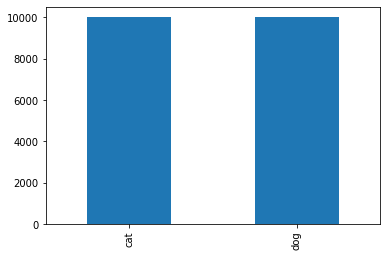

In [319]:
train_df['category'].value_counts().plot.bar()

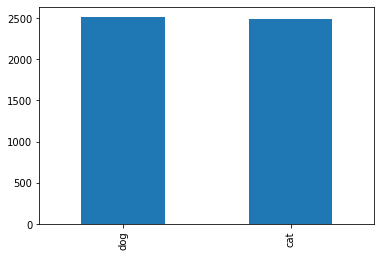

In [320]:
validate_df['category'].value_counts().plot.bar()

In [321]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [322]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)



In [323]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Downloads/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [324]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Downloads/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [325]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "Downloads/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


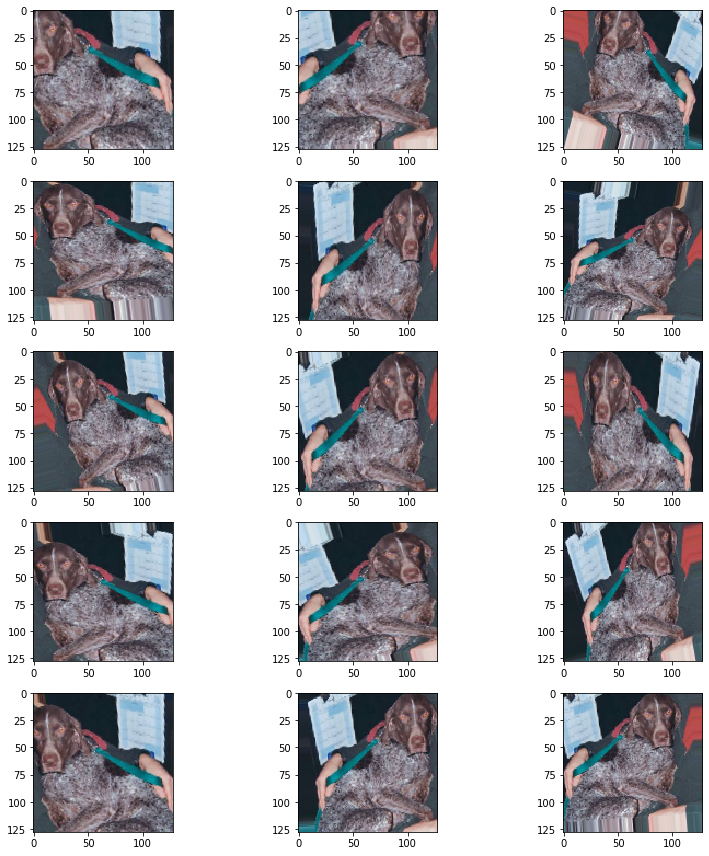

In [326]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [328]:
# epochs=12 #if FAST_RUN else 50
# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )

Epoch 1/12
1333/1333 [==============================] - 1194s 895ms/step - loss: 0.6332 - acc: 0.6677 - val_loss: 0.5537 - val_acc: 0.7083
Epoch 2/12
 118/1333 [=>............................] - ETA: 14:11 - loss: 0.5610 - acc: 0.7288

KeyboardInterrupt: 

In [336]:
epochs=1
history = model.fit_generator(train_generator,validation_data=validation_generator,
     epochs=epochs, callbacks=callbacks)


Epoch 1/1
  18/1334 [..............................] - ETA: 15:42 - loss: 0.6402 - acc: 0.6741

KeyboardInterrupt: 